In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols

# random seed
random_state=0
rng = np.random.RandomState(seed=random_state)

## Load the dataset and create seasonal variables

In [3]:
data_process = pd.read_csv('clean_houses_95.csv',parse_dates=['Time'], index_col='Time') # load the data set

In [4]:
# Keep the the dates with less missing values for most houses
data = data_process.copy(deep=True)
data = data['2014-04':'2015-03']

In [5]:
# Create seasonal variables
#data['Year'] = pd.DatetimeIndex(data.index).year
data['Month'] = pd.DatetimeIndex(data.index).month
data['Week'] = pd.DatetimeIndex(data.index).week
data['DayOfMonth'] = pd.DatetimeIndex(data.index).day
#data['DayOfWeek'] =  pd.DatetimeIndex(data.index).dayofweek
data['Day'] = pd.DatetimeIndex(data.index).weekday_name
data['Hour'] =  pd.DatetimeIndex(data.index).hour

In [6]:
# keep the house of choice for modelling
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
house_nr = 1
drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
data = data.drop(drop_houses, axis=1)

In [7]:
# drop nan values
data = data.dropna(axis=0,how='any')

In [8]:
data.head()

,House_1,Month,Week,DayOfMonth,Day,Hour
Time,,,,,,
2014-04-01 00:00:00,0.848060,4,14,1,Tuesday,0
2014-04-01 01:00:00,0.961215,4,14,1,Tuesday,1
2014-04-01 02:00:00,0.873575,4,14,1,Tuesday,2
2014-04-01 03:00:00,0.893387,4,14,1,Tuesday,3
2014-04-01 04:00:00,0.852123,4,14,1,Tuesday,4


## Create extra features

In [9]:
# Week days Feature
data.loc[(data['Day'] == 'Monday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Saturday', 'WeekDays')] = 'Saturday'
data.loc[(data['Day'] == 'Sunday', 'WeekDays')] = 'Sunday'
data.loc[(data['Day'] == 'Tuesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Wednesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Thursday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Friday', 'WeekDays')] = 'WeekDays'

In [10]:
# Season feature
data.loc[ (data['Month'] == 1), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 2), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 12), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 3),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 4),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 5),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 6), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 7), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 8), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 9), 'Season'] = 'Autumn' 
data.loc[ (data['Month'] == 10), 'Season'] = 'Autumn' 
data.loc[ (data['Month'] == 11), 'Season'] = 'Autumn' 

In [11]:
# Time bulk feature
time_bulk_1 = [1,2,3,4]
time_bulk_2 = [5,6,7,8]
time_bulk_3 = [9,10,11,12]
time_bulk_4 = [13,14,15,16]
time_bulk_5 = [17,18,19,20]
time_bulk_6 = [21,22,23,0]
for i in range(0,24):
    if i in time_bulk_1:
        data.loc[(data['Hour'] == i), 'Time_bulk'] = 'Midnight'
    elif i in time_bulk_2:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Morning'
    elif i in time_bulk_3:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Noon'
    elif i in time_bulk_4:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Afternoon'
    elif i in time_bulk_5:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Evening'
    else:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Night'

In [12]:
# create trend 
data = data.assign(Trend = pd.Series(np.arange(len(data))+1).values)

In [13]:
# create trend square
x = (np.arange(data.shape[0]))**2 + 1
data = data.assign(Trend_square = pd.Series(x).values)

## Prepare data for modeling

In [14]:
data_modeling = data.copy(deep=True)

In [15]:
data_modeling.columns

Index(['House_1', 'Month', 'Week', 'DayOfMonth', 'Day', 'Hour', 'WeekDays',
       'Season', 'Time_bulk', 'Trend', 'Trend_square'],
      dtype='object')

In [16]:
# drop unwanted features
cols = ['Week','Day','Season','Time_bulk','Trend','Trend_square']
data_modeling = data_modeling.drop(cols, axis=1)

In [17]:
data_modeling.columns

Index(['House_1', 'Month', 'DayOfMonth', 'Hour', 'WeekDays'], dtype='object')

In [18]:
# creating dummy variables
cols =  ['DayOfMonth', 'Hour', 'WeekDays']
data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)

In [19]:
# split depedent and indepedent variables
house = 'House_' + str(house_nr)
x_train = data_ook.drop(house,axis=1).values.astype(np.float)
y_train = data_ook[house].values

#### consumption = month + day_of_month + hour + day_of_week

## Linear Regression with cross validation

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [21]:
# split data set for ts k-fold cross validation
tscv = TimeSeriesSplit(n_splits=5)

# add bias term
fit_bias = False

# Create linear regression object
lrm1 = linear_model.LinearRegression(fit_intercept= fit_bias)
lrm2 = linear_model.LinearRegression(fit_intercept= fit_bias)

# train on the whole data
pred = linear_model.LinearRegression(fit_intercept=fit_bias).fit(X = x_train, y= y_train).predict(x_train)

# cross validation
scores_mae  = cross_val_score(lrm1, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
scores_mde  = cross_val_score(lrm2, x_train, y_train, cv=tscv, scoring='neg_median_absolute_error')

# print scores
print('On training set, the model achieves R_2 score: {0:.3f}, MAE: {1:.3f}, MDE:{2:.3f}'.format(metrics.r2_score(y_true=y_train,y_pred=pred),metrics.mean_squared_error(y_true=y_train,y_pred=pred),metrics.median_absolute_error(y_true=y_train,y_pred=pred)))
print('On validation set, the model achieves MAE: {0:.3f}, MDE:{1:.3f}'.format(abs(scores_mae.mean()),abs(scores_mde.mean())))

On training set, the model achieves R_2 score: 0.156, MAE: 0.059, MDE:0.138
On validation set, the model achieves MAE: 0.347, MDE:0.275


## Ridge Regression

In [22]:
# split data set for ts k-fold cross validation
tscv = TimeSeriesSplit(n_splits=5)

# add bias term
fit_bias = False

# model selection for regularization penalty
ridge1 = linear_model.RidgeCV(alphas=[0.9, 0.5, 0.1, 0.05, 0.01, 0.001], cv=tscv, fit_intercept=fit_bias).fit(X = x_train, y= y_train)

# train on the whole data
pred = linear_model.Ridge(alpha= ridge1.alpha_, fit_intercept=fit_bias).fit(X = x_train, y= y_train).predict(x_train)

# Create ridge regression objects
ridge2 = linear_model.Ridge(alpha= ridge1.alpha_, fit_intercept=fit_bias)
ridge3 = linear_model.Ridge(alpha= ridge1.alpha_, fit_intercept=fit_bias)

# cross validation
scores_mae  = cross_val_score(ridge2, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
scores_mde  = cross_val_score(ridge3, x_train, y_train, cv=tscv, scoring='neg_median_absolute_error')

# print scores
print('The best model was found for regularization penalty: {}'.format(ridge1.alpha_))
print('On training set, the model achieves R_2 score: {0:.3f}, MAE: {1:.3f}, MDE:{2:.3f}'.format(metrics.r2_score(y_true=y_train,y_pred=pred),metrics.mean_squared_error(y_true=y_train,y_pred=pred),metrics.median_absolute_error(y_true=y_train,y_pred=pred)))
print('On validation set, the model achieves MAE: {0:.3f}, MDE:{1:.3f}'.format(abs(scores_mae.mean()),abs(scores_mde.mean())))

The best model was found for regularization penalty: 0.9
On training set, the model achieves R_2 score: 0.156, MAE: 0.059, MDE:0.138
On validation set, the model achieves MAE: 0.329, MDE:0.255


# Linear regression model with anova stats

In [23]:
data.columns

Index(['House_1', 'Month', 'Week', 'DayOfMonth', 'Day', 'Hour', 'WeekDays',
       'Season', 'Time_bulk', 'Trend', 'Trend_square'],
      dtype='object')

In [24]:
model_3 = ols(formula='House_1 ~ C(Month) + C(DayOfMonth) + C(WeekDays) + C(Hour) -1', data=data, missing='drop').fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                House_1   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     22.86
Date:                Wed, 28 Jun 2017   Prob (F-statistic):          4.67e-247
Time:                        19:25:42   Log-Likelihood:                -20.629
No. Observations:                8258   AIC:                             175.3
Df Residuals:                    8191   BIC:                             645.5
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(Month)[1]               

In [25]:
print(sm.stats.anova_lm(model_3, typ=2))

                   sum_sq      df          F         PR(>F)
C(Month)        65.623698    12.0  92.181981  1.130879e-214
C(DayOfMonth)    8.597445    30.0   4.830752   7.992549e-17
C(WeekDays)      0.848163     2.0   7.148519   7.909406e-04
C(Hour)         23.824694    23.0  17.460878   6.010039e-69
Residual       485.926228  8191.0        NaN            NaN


## Feature Importance with Random Forests

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
data_modeling.columns

Index(['House_1', 'Month', 'DayOfMonth', 'Hour', 'WeekDays'], dtype='object')

In [28]:
# creating dummy variables
cols =  ['Month', 'DayOfMonth', 'Hour', 'WeekDays']
data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=False)

# split depedent and indepedent variables and separate 100 values for plotting 
house = 'House_' + str(house_nr)
x_train = data_ook[:-100].drop(house,axis=1).values.astype(np.float)
y_train = data_ook[house].values[:-100]
x_test = data_ook[-100:].drop(house,axis=1).values.astype(np.float)
y_test = data_ook[house].values[-100:]

In [29]:
# fit random forest model
model = RandomForestRegressor(n_estimators=500, max_features=x_train.shape[1], random_state=rng, n_jobs=-1)
model.fit(X=x_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=70, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x0000025615D6A9D8>,
           verbose=0, warm_start=False)

In [30]:
# create importance scores per variable
Month = model.feature_importances_[0:12].sum()
DayOfMonth = model.feature_importances_[12:43].sum()
Hour = model.feature_importances_[43:67].sum()
WeekDays = model.feature_importances_[67:].sum()
values = [Month,DayOfMonth,WeekDays,Hour]

In [31]:
# metrics on training set
pred = model.predict(x_train)
adjusted_r_squared = 1 - (1-metrics.r2_score(y_true=y_train,y_pred=pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
print('On training set, the model achieves R_2 score: {0:.3f}, Adjusted R_2: {1:.3f}  MAE: {2:.3f}, MDE:{3:.3f}'.format(metrics.r2_score(y_true=y_train,y_pred=pred),adjusted_r_squared,metrics.mean_squared_error(y_true=y_train,y_pred=pred),metrics.median_absolute_error(y_true=y_train,y_pred=pred)))

On training set, the model achieves R_2 score: 0.907, Adjusted R_2: 0.906  MAE: 0.006, MDE:0.021


In [32]:
# split data set for ts k-fold cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Create linear regression object
rf1 = RandomForestRegressor(n_estimators=500, max_features=x_train.shape[1], random_state=rng, n_jobs=-1)
rf2 = RandomForestRegressor(n_estimators=500, max_features=x_train.shape[1], random_state=rng, n_jobs=-1)
rf3 = RandomForestRegressor(n_estimators=500, max_features=x_train.shape[1], random_state=rng, n_jobs=-1)

# cross validation
scores_r2 = cross_val_score(rf1, x_train, y_train, cv=tscv, scoring='r2')
scores_mae  = cross_val_score(rf2, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
scores_mde  = cross_val_score(rf3, x_train, y_train, cv=tscv, scoring='neg_median_absolute_error')

print('On validation set, the model achieves MAE: {0:.3f}, MDE:{1:.3f}'.format(abs(scores_mae.mean()),abs(scores_mde.mean())))

On validation set, the model achieves MAE: 0.187, MDE:0.101


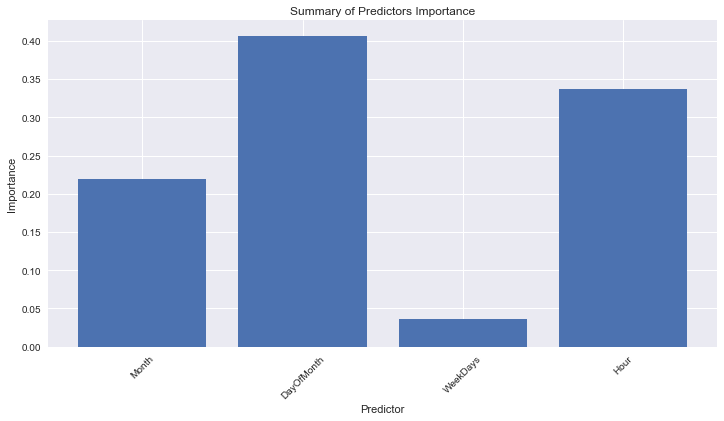

In [33]:
# plot importance scores
names = ['Month','DayOfMonth','WeekDays','Hour']
values = np.asarray(values)
ticks = [i for i in range(len(names))]
plt.figure(figsize=(12,6))
plt.bar(ticks,values)
plt.xticks(ticks, names,rotation=45)
plt.xlabel('Predictor')
plt.ylabel('Importance')
plt.title('Summary of Predictors Importance')
plt.show()

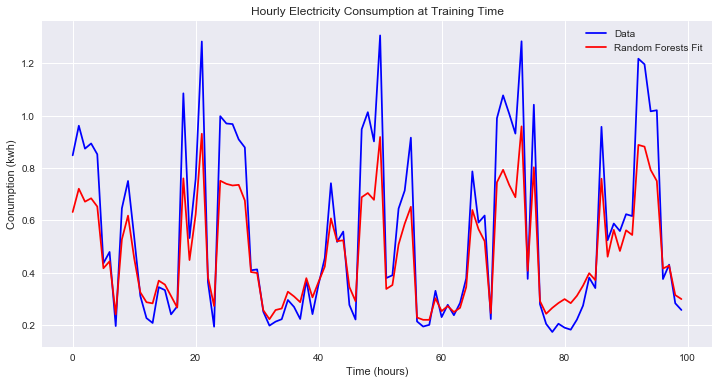

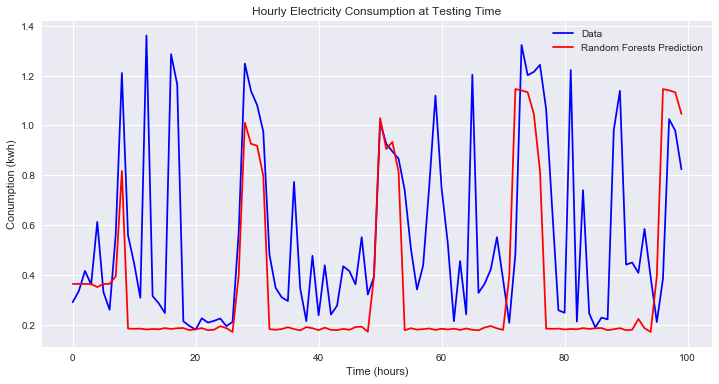

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
fig1, ax1 = plt.subplots(figsize=(12,6))
x = np.arange(100)
ax.plot(x,data.House_1[0:100], 'b-', label="Data")
ax.plot(x,pred[0:100], 'r-', label="Random Forests Fit")
ax.set_ylabel('Conumption (kwh)')
ax.set_xlabel('Time (hours)')
ax.legend(loc='best')
ax.set_title('Hourly Electricity Consumption at Training Time')

ax1.plot(x,y_test, 'b-', label="Data")
ax1.plot(x,model.predict(x_test), 'r-', label="Random Forests Prediction")
ax1.set_ylabel('Conumption (kwh)')
ax1.set_xlabel('Time (hours)')
ax1.legend(loc='best')
plt.title('Hourly Electricity Consumption at Testing Time')
plt.show()

## Gradient Boosting Regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
data_modeling.columns

Index(['House_1', 'Month', 'DayOfMonth', 'Hour', 'WeekDays'], dtype='object')

In [37]:
# creating dummy variables
cols =  ['Month', 'DayOfMonth', 'Hour', 'WeekDays']
data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=False)

# split depedent and indepedent variables
house = 'House_' + str(house_nr)
x_train = data_ook.drop(house,axis=1).values.astype(np.float)
y_train = data_ook[house].values

In [38]:
# fit random forest model
model = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1,max_depth=1, random_state=rng, loss='ls')
model.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto',
             random_state=<mtrand.RandomState object at 0x0000013198B7C438>,
             subsample=1.0, verbose=0, warm_start=False)

In [39]:
# create importance scores per variable
Month = model.feature_importances_[0:12].sum()
DayOfMonth = model.feature_importances_[12:43].sum()
Hour = model.feature_importances_[43:67].sum()
WeekDays = model.feature_importances_[67:].sum()
values = [Month,DayOfMonth,WeekDays,Hour]

In [40]:
# metrics on training set
pred = model.predict(x_train)
print('On training set, the model achieves R_2 score: {0:.3f}, MAE: {1:.3f}, MDE:{2:.3f}'.format(metrics.r2_score(y_true=y_train,y_pred=pred),metrics.mean_squared_error(y_true=y_train,y_pred=pred),metrics.median_absolute_error(y_true=y_train,y_pred=pred)))

On training set, the model achieves R_2 score: 0.144, MAE: 0.111, MDE:0.163


In [43]:
# split data set for ts k-fold cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Create linear regression object
gbr2 = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1,max_depth=1, random_state=rng, loss='ls')
gbr3 = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1,max_depth=1, random_state=rng, loss='ls')

# cross validation
scores_mae = cross_val_score(gbr2, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
scores_mde = cross_val_score(gbr3, x_train, y_train, cv=tscv, scoring='neg_median_absolute_error')

print('On validation set, the model achieves MAE: {0:.3f}, MDE:{1:.3f}'.format(abs(scores_mae.mean()),abs(scores_mde.mean())))

On validation set, the model achieves MAE: 0.234, MDE:0.142


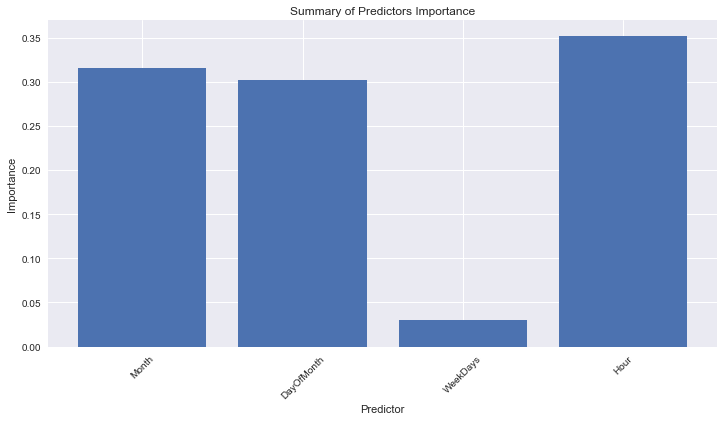

In [42]:
# plot importance scores
names = ['Month','DayOfMonth','WeekDays','Hour']
values = np.asarray(values)
ticks = [i for i in range(len(names))]
plt.figure(figsize=(12,6))
plt.bar(ticks,values)
plt.xticks(ticks, names,rotation=45)
plt.xlabel('Predictor')
plt.ylabel('Importance')
plt.title('Summary of Predictors Importance')
plt.show()

## Support vector regression

In [14]:
from sklearn.svm import SVR

In [15]:
data_modeling.columns

Index(['House_1', 'Month', 'Week', 'DayOfMonth', 'Day', 'Hour', 'WeekDays',
       'Season', 'Time_bulk', 'Trend', 'Trend_square'],
      dtype='object')

In [26]:
# creating dummy variables
cols =  ['Month', 'DayOfMonth', 'Hour', 'WeekDays']
data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)

# split depedent and indepedent variables and separate 100 values for plotting 
house = 'House_' + str(house_nr)
x_train = data_ook[:-100].drop(house,axis=1).values.astype(np.float)
y_train = data_ook[house].values[:-100]
x_test = data_ook[-100:].drop(house,axis=1).values.astype(np.float)
y_test = data_ook[house].values[-100:]

In [28]:
# initialize and fit models
svr_rbf = SVR(kernel='rbf', C=1e3, cache_size = 1000)
y_rbf = svr_rbf.fit(x_train, y_train).predict(x_train)
# metrics on training set
adjusted_r_squared_rbf = 1 - (1-metrics.r2_score(y_true=y_train,y_pred=y_rbf))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
print('Training set metrics:')
print('SVR with RBF kernels achieves R_2 score: {0:.3f}, Adjusted R_2: {1:.3f}  MAE: {2:.3f}, MDE:{3:.3f}'.format(metrics.r2_score(y_true=y_train,y_pred=y_rbf),adjusted_r_squared_rbf,metrics.mean_squared_error(y_true=y_train,y_pred=y_rbf),metrics.median_absolute_error(y_true=y_train,y_pred=y_rbf)))

Training set metrics:
SVR with RBF kernels achieves R_2 score: 0.488, Adjusted R_2: 0.484  MAE: 0.066, MDE:0.099


In [25]:
# split data set for ts k-fold cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Create linear regression object
svr_rbf1 = SVR(kernel='rbf', C=1e3, cache_size = 1000)
svr_rbf2 = SVR(kernel='rbf', C=1e3, cache_size = 1000)

# cross validation
scores_mae = cross_val_score(svr_rbf1, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
scores_mde = cross_val_score(svr_rbf2, x_train, y_train, cv=tscv, scoring='neg_median_absolute_error')

print('On validation set, the model achieves MAE: {0:.3f}, MDE:{1:.3f}'.format(abs(scores_mae.mean()),abs(scores_mde.mean())))

On validation set, the model achieves MAE: 0.227, MDE:0.133


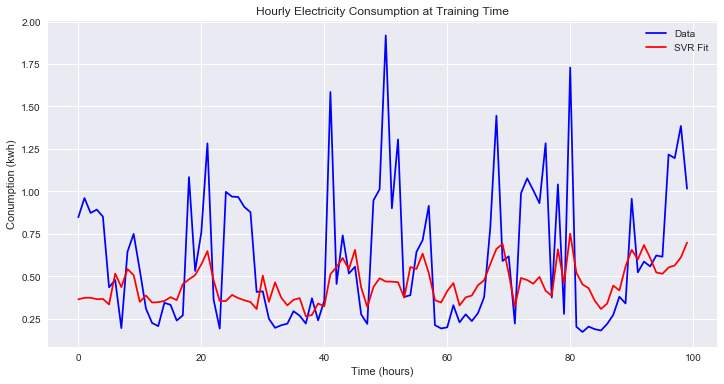

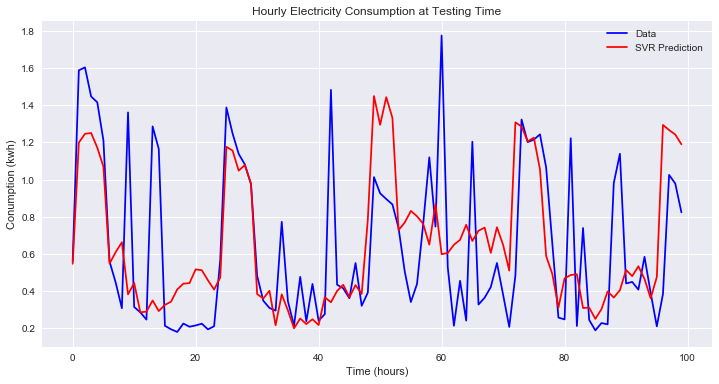

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
fig1, ax1 = plt.subplots(figsize=(12,6))
x = np.arange(100)
ax.plot(x,data.House_1[0:100], 'b-', label="Data")
ax.plot(x,y_rbf[0:100], 'r-', label="SVR Fit")
ax.set_ylabel('Conumption (kwh)')
ax.set_xlabel('Time (hours)')
ax.legend(loc='best')
ax.set_title('Hourly Electricity Consumption at Training Time')

ax1.plot(x,y_test, 'b-', label="Data")
ax1.plot(x,svr_rbf.predict(x_test), 'r-', label="SVR Prediction")
ax1.set_ylabel('Conumption (kwh)')
ax1.set_xlabel('Time (hours)')
ax1.legend(loc='best')
plt.title('Hourly Electricity Consumption at Testing Time')
plt.show()